### Install PySpark

In [66]:
!pip install pyspark

### Create Spark Context

In [67]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark import SparkFiles

In [68]:
spark = SparkContext.getOrCreate()

### Load Dataset

In [69]:
spark.addFile('https://raw.githubusercontent.com/JonatasDeOliveira/movie-it/master/src/data/moviesOnStreamingPlatforms_updated.csv')

In [70]:
sql_context = SQLContext(spark)
movies_df = sql_context.read.csv(SparkFiles.get("moviesOnStreamingPlatforms_updated.csv"), header=True, inferSchema= True)

In [71]:
movies_df.show(20, False)

+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|_c0|ID |Title                             |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Type|Directors                                  |Genres                                  |Country                                    |Language                                   |Runtime|
+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|0  |1  |Inception                         |2010|13+|8.8 |87%            |1      |0   |0          |0      |0   |Christ

### Pre Processing Dataset 

In [72]:
movies_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Type: integer (nullable = true)
 |-- Directors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Runtime: integer (nullable = true)



Pontos notados:

- Primeiramente, percebemos que temos duas colunas com "ids". Como pegamos esses dados do kaggle possivelmente esta primeira coluna não é necessária.
- Há uma coluna Type que possui somente valores iguais a 0. Procuramos entender o que seria mas não encontramos, vamos dropar essa coluna.
- Outra observação é que as colunas Directors, Genres, Country e Language são listas e estão como strings devemos processar também as mesmas.
- Colunas Age e Year estão como string, devem ser transformadas para integer.

In [73]:
from pyspark.sql.functions import split
from pyspark.sql.functions import col

In [74]:
movies_df_drop_c0 = movies_df.drop('_c0')

In [75]:
movies_df_drop_type = movies_df_drop_c0.drop('Type')

In [76]:
movies_df_split = (movies_df_drop_type.withColumn('DirectorsArray', split('Directors', ','))
.withColumn('GenresArray', split('Genres', ','))
.withColumn('CountriesArray', split('Country', ','))
.withColumn('LanguagesArray', split('Language', ','))
.drop('Directors')
.drop('Genres')
.drop('Country')
.drop('Language'))

In [77]:
# checando se todas as idades seguem o regex [0-9]+\+
df_filtered_age_pattern = movies_df_split.filter(col('Age').rlike('[0-9]+\+'))
df_filtered_age_pattern.count() == movies_df_split.count()

False

In [78]:
# verificar idades que não seguem o padrão
df_filtered_not_age_pattern = movies_df_split.filter(~col('Age').rlike('[0-9]+\+'))
df_filtered_not_age_pattern.show(5, False)

+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|ID |Title                              |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray             |GenresArray                                                      |CountriesArray                                      |LanguagesArray                    |
+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|55 |Willy Wonka & the Chocolate Factory|1971|all|7.8 |91%            |1      |0   |0          |0      |100    |[Me

In [79]:
# verficar que o padrão de idade em regex [0-9]+\+ unido a o padrão com 'all' contemplam todo o dataframe
df_filtered_pattern_all = movies_df_split.filter(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all'))
movies_df_split.count() == df_filtered_pattern_all.count()

False

In [80]:
df_filtered_not_pattern_all = movies_df_split.filter(~(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all')))
df_filtered_not_pattern_all.show(5, False)

+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|ID   |Title                        |Year                     |Age |IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray|GenresArray|CountriesArray|LanguagesArray|
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|15902|"""22"" A film about Veterans| Healthcare and Suicide."|2018|null|null           |null   |0   |0          |1      |null   |[0]           |null       |null          |null          |
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+



Claramente a linha apresentada acima é um erro pois a idade está como um ano, o ano está como um texto e a maioria das outras colunas estão vazias, vamos remover essa linha.

In [81]:
movies_df_filtered_age = movies_df_split.where(col('ID') != 15902)

Agora vamos processar Age para aparecer como um inteiro em todo dataframe. A idade (Age) possui dois formatos, a idade mínima pra assistir o filme acompanhada de um caracter '+' ou o texto escrito 'all'. Iremos seguir os seguintes passos:
- remover o caracter '+' das idades mínimas;
- tranformar todas linha com o valor 'all' para 0;
- transformar para um inteiro renomeando a coluna para MinimumAge;

In [82]:
movies_df_filtered_age.where(col('Age').isNull()).show()

+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| ID|               Title|Year| Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|      DirectorsArray|         GenresArray|      CountriesArray|      LanguagesArray|
+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| 33|      Train to Busan|2016|null| 7.5|            94%|      1|   0|          1|      0|    118|      [Sang-ho Yeon]|[Action, Horror, ...|       [South Korea]|  [Korean, Hawaiian]|
| 58|      A Silent Voice|2016|null| 8.2|            94%|      1|   0|          0|      0|    130|      [Naoko Yamada]|[Animation, Drama...|             [Japan]|[Japanese, Japane...|
| 90|       The Dawn Wall|2018|null| 8.1|           100%|      1|   0|          0|   

In [83]:
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def transform_all_age_value(age):
  if age == 'all':
    return 0
  if age is None:
    return -1
  return int(age)

transformAllAgeValue = udf(lambda x: transform_all_age_value(x), IntegerType())

movies_df_age_processed = movies_df_filtered_age.withColumn("Age", translate('Age', '+', ''))
movies_df_classification = movies_df_age_processed.withColumn("MinimumClassification", transformAllAgeValue(col('Age'))).drop('Age')

Note que existe idade indicativa nula, setamos esses valores como -1.

In [84]:
movies_df_classification.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Analisando o schema novamente, podemos ver que assim como o campo Age, o campo Year deveria estar como Integer, vamos arrumar isso.

In [85]:
movies_df_year_processed = movies_df_classification.withColumn("Year", col("Year").cast(IntegerType()))

In [86]:
movies_df_year_processed.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Agora precisamos modificar a coluna Rotten Tomatoes para ser um integer.

In [87]:
movies_df_rotten_char = movies_df_year_processed.withColumn("RottenTomatoes", translate('Rotten Tomatoes', '%', '')).drop('Rotten Tomatoes')
movies_df_rotten_int = movies_df_rotten_char.withColumn("RottenTomatoes", col("RottenTomatoes").cast(IntegerType()))
movies_df_padronized_rotten = movies_df_rotten_int.withColumn("RottenTomatoes", col("RottenTomatoes") / 10)

In [88]:
movies_df_padronized_rotten.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)
 |-- RottenTomatoes: double (nullable = true)



In [89]:
movies_df_processed = movies_df_padronized_rotten

In [90]:
movies_df_processed.orderBy('IMDb', ascending=False).show(1, False)

+----+---------------+----+----+-------+----+-----------+-------+-------+--------------+---------------------------------+---------------+--------------+---------------------+--------------+
|ID  |Title          |Year|IMDb|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray|GenresArray                      |CountriesArray |LanguagesArray|MinimumClassification|RottenTomatoes|
+----+---------------+----+----+-------+----+-----------+-------+-------+--------------+---------------------------------+---------------+--------------+---------------------+--------------+
|5111|Love on a Leash|2011|9.3 |0      |0   |1          |0      |90     |[Fen Tian]    |[Comedy, Drama, Fantasy, Romance]|[United States]|null          |-1                   |null          |
+----+---------------+----+----+-------+----+-----------+-------+-------+--------------+---------------------------------+---------------+--------------+---------------------+--------------+
only showing top 1 row



In [91]:
movies_df_processed.where((col("Netflix") == 1) & (col("Prime Video") == 1)).orderBy('IMDb', ascending=False).show(1, False)

+---+------------------------------+----+----+-------+----+-----------+-------+-------+--------------+-----------+----------------------------+--------------+---------------------+--------------+
|ID |Title                         |Year|IMDb|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray|GenresArray|CountriesArray              |LanguagesArray|MinimumClassification|RottenTomatoes|
+---+------------------------------+----+----+-------+----+-----------+-------+-------+--------------+-----------+----------------------------+--------------+---------------------+--------------+
|5  |The Good, the Bad and the Ugly|1966|8.8 |1      |0   |1          |0      |161    |[Sergio Leone]|[Western]  |[Italy, Spain, West Germany]|[Italian]     |18                   |9.7           |
+---+------------------------------+----+----+-------+----+-----------+-------+-------+--------------+-----------+----------------------------+--------------+---------------------+--------------+
only showing top 1 r

In [92]:
movies_df_processed.where((col("Netflix") == 1) & (col("Prime Video") == 1)).orderBy('Rotten Tomatoes', ascending=False).show(1, False)

+---+----------+----+----+-------+----+-----------+-------+-------+-----------------+--------------+----------------+--------------+---------------------+--------------+
|ID |Title     |Year|IMDb|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray   |GenresArray   |CountriesArray  |LanguagesArray|MinimumClassification|RottenTomatoes|
+---+----------+----+----+-------+----+-----------+-------+-------+-----------------+--------------+----------------+--------------+---------------------+--------------+
|143|Starred Up|2013|7.4 |1      |0   |1          |0      |106    |[David Mackenzie]|[Crime, Drama]|[United Kingdom]|[English]     |18                   |9.9           |
+---+----------+----+----+-------+----+-----------+-------+-------+-----------------+--------------+----------------+--------------+---------------------+--------------+
only showing top 1 row



### Visualization

In [93]:
movies_df_pd = movies_df_processed.toPandas()

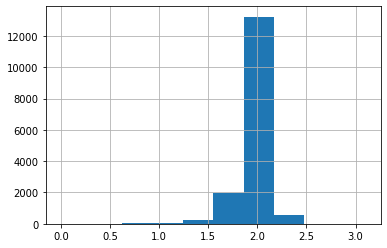

In [95]:
from numpy import log10
movies_df_pd['runtime_log'] = log10(movies_df_pd['Runtime'])
movies_df_pd['runtime_log'].hist()

In [96]:
movies_df_pd.corr(method='spearman')

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,runtime_log
ID,1.000000,-0.338757,-0.387162,-0.708695,-0.219733,0.554128,0.287020,-0.273610,-0.161186,-0.280077,-0.273610
Year,-0.338757,1.000000,-0.004339,0.365579,0.130545,-0.351349,-0.086546,0.064729,-0.044372,0.081174,0.064729
IMDb,-0.387162,-0.004339,1.000000,0.127438,0.034747,-0.153996,0.074947,0.122031,-0.075147,0.622257,0.122031
Netflix,-0.708695,0.365579,0.127438,1.000000,-0.107919,-0.757211,-0.088934,0.139293,0.034287,0.022120,0.139293
Hulu,-0.219733,0.130545,0.034747,-0.107919,1.000000,-0.255636,-0.034320,0.047928,0.102220,0.018817,0.047928
Prime Video,0.554128,-0.351349,-0.153996,-0.757211,-0.255636,1.000000,-0.298897,-0.107562,-0.078533,-0.047702,-0.107562
Disney+,0.287020,-0.086546,0.074947,-0.088934,-0.034320,-0.298897,1.000000,-0.012797,0.061495,-0.015064,-0.012797
Runtime,-0.273610,0.064729,0.122031,0.139293,0.047928,-0.107562,-0.012797,1.000000,0.157158,-0.014612,1.000000
MinimumClassification,-0.161186,-0.044372,-0.075147,0.034287,0.102220,-0.078533,0.061495,0.157158,1.000000,-0.212649,0.157158
RottenTomatoes,-0.280077,0.081174,0.622257,0.022120,0.018817,-0.047702,-0.015064,-0.014612,-0.212649,1.000000,-0.014612


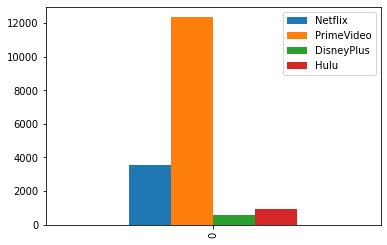

In [97]:
movies_df_processed = movies_df_processed.withColumnRenamed('Prime Video', 'PrimeVideo')
movies_df_processed = movies_df_processed.withColumnRenamed('Disney+', 'DisneyPlus')

movies_df_processed.createOrReplaceTempView("movies")
sqlDF = sql_context.sql("SELECT SUM(Netflix) AS Netflix, SUM(PrimeVideo) AS PrimeVideo, SUM(DisneyPlus) AS DisneyPlus, SUM(Hulu) AS Hulu FROM movies")
sqlDF.toPandas().plot.bar()

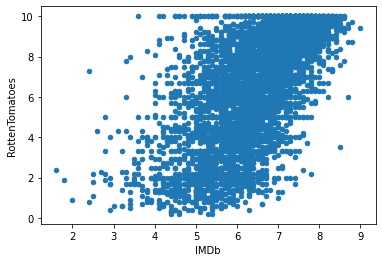

In [98]:
movies_df_pd.plot.scatter(x='IMDb',y='RottenTomatoes')

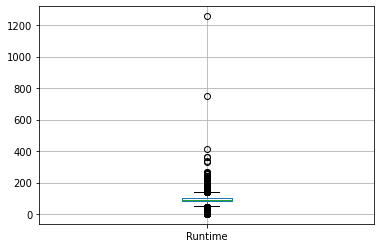

In [100]:
movies_df_pd.boxplot(column='Runtime')

In [101]:
from numpy import abs
mad = abs(movies_df_pd['runtime_log'] - movies_df_pd['runtime_log'].median()).median()*(1/0.6745)
print(mad)

0.07409040023993868


In [102]:
#mad = movies_df_pd['runtime_log'].mad()

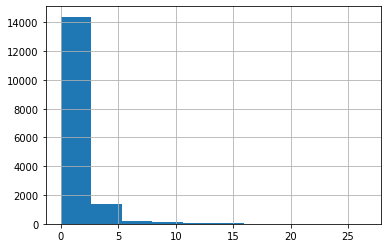

In [103]:
(abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad).hist()

In [104]:
movies_df_mad = movies_df_pd[abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad < 6]
movies_df_mad

,ID,Title,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,DirectorsArray,GenresArray,CountriesArray,LanguagesArray,MinimumClassification,RottenTomatoes,runtime_log
0,1,Inception,2010,8.8,1,0,0,0,148.0,[Christopher Nolan],"[Action, Adventure, Sci-Fi, Thriller]","[United States, United Kingdom]","[English, Japanese, French]",13,8.7,2.170262
1,2,The Matrix,1999,8.7,1,0,0,0,136.0,"[Lana Wachowski, Lilly Wachowski]","[Action, Sci-Fi]",[United States],[English],18,8.7,2.133539
2,3,Avengers: Infinity War,2018,8.5,1,0,0,0,149.0,"[Anthony Russo, Joe Russo]","[Action, Adventure, Sci-Fi]",[United States],[English],13,8.4,2.173186
3,4,Back to the Future,1985,8.5,1,0,0,0,116.0,[Robert Zemeckis],"[Adventure, Comedy, Sci-Fi]",[United States],[English],7,9.6,2.064458
4,5,"The Good, the Bad and the Ugly",1966,8.8,1,0,1,0,161.0,[Sergio Leone],[Western],"[Italy, Spain, West Germany]",[Italian],18,9.7,2.206826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16733,16735,Sultan And The Rock Star,1980,5.9,0,0,0,1,60.0,[Edward M. Abroms],"[Adventure, Drama, Family]",[United States],[English],-1,NaN,1.778151
16736,16738,The Bears and I,1974,6.2,0,0,0,1,89.0,[Bernard McEveety],"[Drama, Family]",[United States],[English],0,NaN,1.949390
16737,16739,Whispers: An Elephant's Tale,2000,5.0,0,0,0,1,72.0,[Dereck Joubert],"[Adventure, Family]",[United States],[English],0,NaN,1.857332
16738,16740,The Ghosts of Buxley Hall,1980,6.2,0,0,0,1,120.0,[Bruce Bilson],"[Comedy, Family, Fantasy, Horror]",[United States],[English],-1,NaN,2.079181


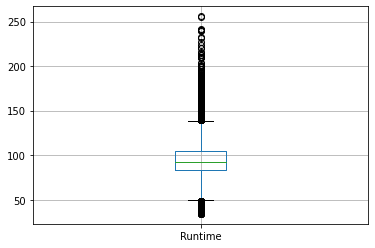

In [105]:
movies_df_mad.boxplot(column='Runtime')

In [141]:
movies_df_mad['normalized_year'] = movies_df_mad['Year'].floordiv(10) * 10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


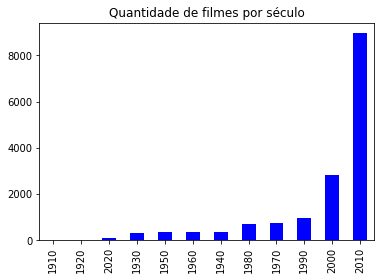

In [142]:
quantity_movies_by_sec = movies_df_mad['normalized_year'].value_counts().sort_values(ascending=True)
quantity_movies_by_sec.plot.bar(color=(0,0,1), title='Quantidade de filmes por século')

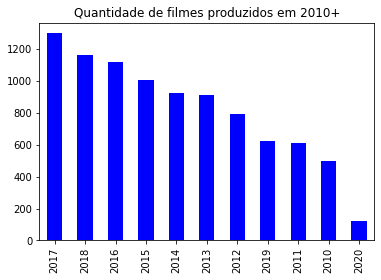

In [159]:
movies_df_2010 = movies_df_mad[movies_df_mad['Year'] >= 2010]
movies_df_2010 = movies_df_2010.sort_values(['Year'])
quantity_movies_2010 = movies_df_2010['Year'].value_counts()
quantity_movies_2010.plot.bar(color=(0,0,1), title='Quantidade de filmes produzidos em 2010+')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


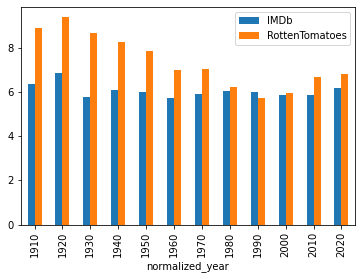

In [202]:
t = movies_df_mad.groupby('normalized_year')['IMDb', 'RottenTomatoes'].mean()
t.plot.bar()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


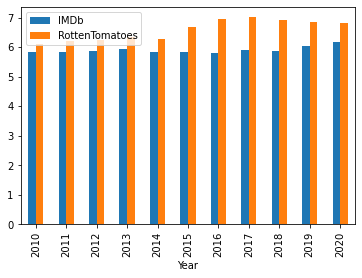

In [203]:
t = movies_df_2010.groupby('Year')['IMDb', 'RottenTomatoes'].mean()
t.plot.bar()

ANALISES
- Qual é mais critico em relacão as notas (imdb ou rotten)
- Quantidade de filmes presentes em cada plataforma
- Alguma relacao de ano + nota / nota + regiao produzida / nota + ator conhecido
- Agrupar por ator para ver qual ator fez mais filme, fazer uma analise do ator + media dos filmes que ele esteve presente
 
HIPOTESES
- Filmes de acao tem uma classificacao indicativa maior
- Filmes de drama / romance tem maior nota no rotten tomatoes
- Existe maior quantidade de filmes em ingles
- Existe maior quantidade de filmes feito nos USA

In [205]:
from pyspark.sql.functions import when,count

movies_df_aval = movies_df_processed.where(col('IMDb').isNotNull() & col('RottenTomatoes').isNotNull())

movies_df_aval.agg(
    count(when(col("IMDb") >= 9, True)).alias('IMDb Count'),
    count(when(col("RottenTomatoes") >= 9, True)).alias('RottenTomatoes Count')
).show()

+----------+--------------------+
|IMDb Count|RottenTomatoes Count|
+----------+--------------------+
|         1|                1126|
+----------+--------------------+

